In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
from glob import glob as glob
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
gsname = 'gs0209'

### load data

In [3]:
#
datadf = datadf1 = pd.read_csv('data/%s-datadf-0.csv'%gsname)
# datadf = datadf2 = pd.read_csv('data/%s-datadf-1.csv'%gsname)

In [4]:
gsdf = pd.read_csv('data/%s-summdf.csv'%gsname).astype(float)
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,mse-e,testacc-i,acc2-i,mse-i,testacc-l,acc2-l,mse-l,testacc-m,acc2-m,mse-m
0,0.0,15.376197,92.606049,10.540349,0.455047,0.0,1.0,1.0,1.0,0.0,...,0.024075,0.793570,0.500000,0.018739,0.843313,0.500000,0.025449,0.861380,0.943860,0.039604
1,0.0,29.408463,82.825523,70.276944,0.421751,0.0,1.0,1.0,1.0,0.0,...,0.043579,0.543685,0.534416,0.011660,0.540560,0.525315,0.049853,0.548125,0.745395,0.040854
2,0.0,14.754186,91.320087,12.010926,0.440664,0.0,1.0,1.0,1.0,0.0,...,0.023284,0.778782,0.500000,0.017914,0.851638,0.500000,0.026357,0.854987,0.944343,0.038547
3,0.0,21.455642,98.301861,88.284464,0.434258,0.0,1.0,1.0,1.0,0.0,...,0.028614,0.519503,0.508360,0.015825,0.510784,0.505096,0.058112,0.509643,0.741863,0.053455
4,0.0,26.329615,88.870500,38.331773,0.652107,0.0,1.0,1.0,1.0,0.0,...,0.043839,0.715960,0.500000,0.014898,0.824778,0.500000,0.028651,0.796695,0.933237,0.038031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,0.0,31.164926,93.278309,77.333007,0.414368,0.0,1.0,1.0,1.0,0.0,...,0.048671,0.539802,0.535139,0.011958,0.527983,0.516334,0.052516,0.556009,0.751748,0.037537
1152,0.0,21.974120,98.564789,42.383673,0.473019,0.0,1.0,1.0,1.0,0.0,...,0.024250,0.502575,0.497321,0.018917,0.511737,0.505702,0.057479,0.502303,0.742715,0.057819
1153,0.0,13.139012,72.796157,12.581312,0.292531,0.0,1.0,1.0,1.0,0.0,...,0.019147,0.823349,0.500000,0.020262,0.837696,0.500000,0.023221,0.841170,0.931241,0.034132
1154,0.0,18.874538,78.383837,72.291072,0.491746,0.0,1.0,1.0,1.0,0.0,...,0.032837,0.507151,0.498715,0.018353,0.505388,0.496968,0.059946,0.507514,0.739872,0.054403


In [5]:
## human data
hdf = pd.read_csv('../human_data.csv')
humanD = {}
for c in ['blocked','interleaved','early','middle','late']:
  humanD[c[0]] = hdf.loc[:,('%s mean')%c].values.T[-40:].mean()
## difference to human
for c in ['b','i','e','m','l']:
  gsdf['%s-test_diff'%c] = np.abs(gsdf.loc[:,'testacc-%s'%c] - humanD[c])

In [6]:
# datadf.columns
# paramL = ['concentration', 'stickiness_wi', 'stickiness_bt',
#        'sparsity', 'pvar', 'lrate', 'lratep', 'decay_rate']

In [7]:
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,acc2-l,mse-l,testacc-m,acc2-m,mse-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff
0,0.0,15.376197,92.606049,10.540349,0.455047,0.0,1.0,1.0,1.0,0.0,...,0.500000,0.025449,0.861380,0.943860,0.039604,0.054778,0.144382,0.045641,0.171043,0.100539
1,0.0,29.408463,82.825523,70.276944,0.421751,0.0,1.0,1.0,1.0,0.0,...,0.525315,0.049853,0.548125,0.745395,0.040854,0.057659,0.105503,0.101174,0.142212,0.202215
2,0.0,14.754186,91.320087,12.010926,0.440664,0.0,1.0,1.0,1.0,0.0,...,0.500000,0.026357,0.854987,0.944343,0.038547,0.057037,0.129594,0.053540,0.164650,0.108864
3,0.0,21.455642,98.301861,88.284464,0.434258,0.0,1.0,1.0,1.0,0.0,...,0.505096,0.058112,0.509643,0.741863,0.053455,0.054261,0.129685,0.061965,0.180694,0.231990
4,0.0,26.329615,88.870500,38.331773,0.652107,0.0,1.0,1.0,1.0,0.0,...,0.500000,0.028651,0.796695,0.933237,0.038031,0.061053,0.066772,0.111120,0.106358,0.082004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,0.0,31.164926,93.278309,77.333007,0.414368,0.0,1.0,1.0,1.0,0.0,...,0.516334,0.052516,0.556009,0.751748,0.037537,0.060201,0.109386,0.092195,0.134329,0.214791
1152,0.0,21.974120,98.564789,42.383673,0.473019,0.0,1.0,1.0,1.0,0.0,...,0.505702,0.057479,0.502303,0.742715,0.057819,0.057611,0.146613,0.048325,0.188035,0.231038
1153,0.0,13.139012,72.796157,12.581312,0.292531,0.0,1.0,1.0,1.0,0.0,...,0.500000,0.023221,0.841170,0.931241,0.034132,0.062683,0.174161,0.064861,0.150833,0.094922
1154,0.0,18.874538,78.383837,72.291072,0.491746,0.0,1.0,1.0,1.0,0.0,...,0.496968,0.059946,0.507514,0.739872,0.054403,0.059328,0.142037,0.077273,0.182824,0.237386


# calc mse

In [8]:
gsdf.loc[:,'mse-bi'] = gsdf.loc[:,'mse-i']+gsdf.loc[:,'mse-b']

### compute df metrics, form summary df

In [9]:
# # subset of dataframe containing relevant params
# Btest = gsdf.loc[:,'testacc-b'] > 0.95
# Itest1 = gsdf.loc[:,'testacc-i'] > 0.6
# Itest2 = gsdf.loc[:,'testacc-i'] < 0.65
# Etest = gsdf.loc[:,'testacc-e'] > 0.8
# Mtest = gsdf.loc[:,'testacc-m'] < 0.9
# Mtest2 = gsdf.loc[:,'testacc-m'] < 0.85
# Ltest = gsdf.loc[:,'testacc-l'] < 0.9
# Iblock2 = gsdf.loc[:,'acc2-i'] > 0.51
# skipt1 = gsdf.loc[:,'skipt1'] == 0
# MItest = gsdf.loc[:,'testacc-m'] - gsdf.loc[:,'testacc-i'] > 0.1
# LItest = gsdf.loc[:,'testacc-l'] - gsdf.loc[:,'testacc-i'] > 0.1

# C = Btest&Mtest&Ltest
# sgsdf = gsdf[C]
# sgsdf = sgsdf.sort_values('testacc-l',ascending=False)
# sgsdf

### plt single condition

In [10]:
def get_cond_df(row):
  ## form query string for above row
  query_str = " and ".join(
    ["%s == %f"%(k,v) for k,v in dict(row.astype(float)[1:10].round(4)).items()]
  )
  print('query',query_str)
  ## df of single parameter condition`
  cond_df = datadf1.round(4).query(query_str)
  if not len(cond_df):
    cond_df = datadf2.round(4).query(query_str)
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  print('found',paramstr)
  return cond_df


In [11]:
def plt_cond_df(cond_df,title_extra=''):
  f,axar = plt.subplots(1,1,figsize=(20,8))
  ax=axar
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  for c,cdf in cond_df.groupby('cond'):
    try:
#       if c not in ['blocked','interleaved']:
#         print('FIGURES WITH BI ONLY')
#         continue
      ax.plot(np.arange(200),cdf.acc,label=c)
    except:
      print('err',paramstr,c)
      continue
  ax.set_ylim(0,1)
  plt.legend()
  plt.axhline(0.5,c='k',ls='--')
  
  plt.title("%s\n%s\nMSE=%s"%(paramstr[:94],paramstr[94:],title_extra))
  plt.savefig('figures/analysis_gs/acc-%s.png'%paramstr)


In [12]:
## select single param for plotting full acc trace
# row = sgsdf.sort_values('testacc-l',ascending=False).iloc[0]
# print(row.astype(float))
# cond_df = get_cond_df(row)

Unnamed: 0        0.000000
concentration    23.295433
stickiness_wi    74.287205
stickiness_bt    78.021423
sparsity          0.228974
pvar              0.000000
lrate             1.000000
lratep            1.000000
decay_rate        1.000000
skipt1            0.000000
testacc-b         0.854407
acc2-b            0.664872
mse-b             0.022491
testacc-e         0.810732
acc2-e            0.604820
mse-e             0.033280
testacc-i         0.593232
acc2-i            0.582563
mse-i             0.007510
testacc-l         0.568952
acc2-l            0.562029
mse-l             0.035541
testacc-m         0.573172
acc2-m            0.739577
mse-m             0.030995
b-test_diff       0.059003
i-test_diff       0.055956
e-test_diff       0.097400
m-test_diff       0.117165
l-test_diff       0.173822
mse-bi            0.030001
Name: 336, dtype: float64
query concentration == 23.295400 and stickiness_wi == 74.287200 and stickiness_bt == 78.021400 and sparsity == 0.229000 and pvar == 0.000

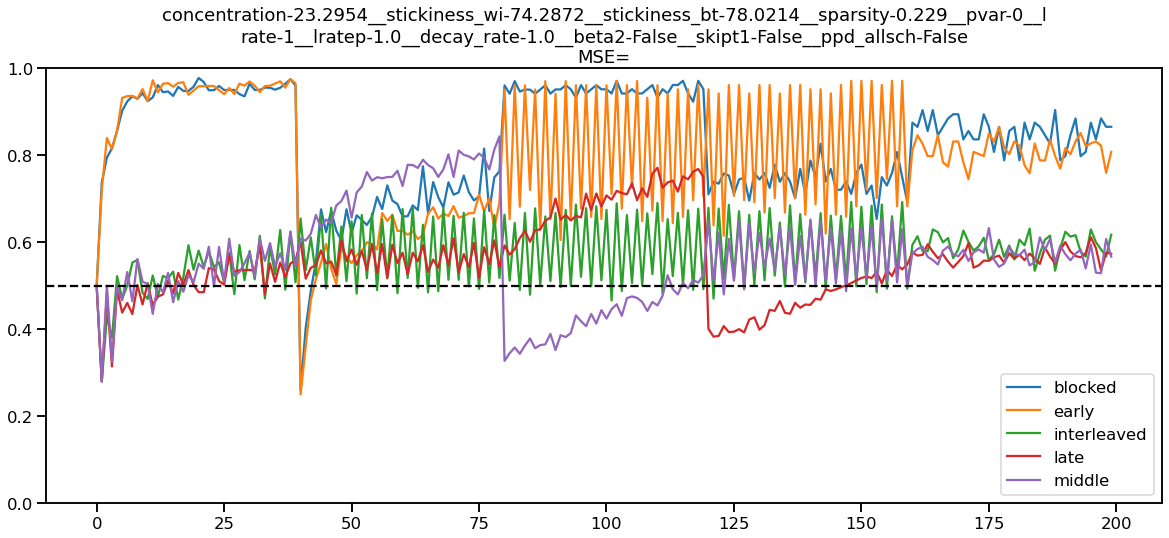

In [13]:
## TOP PARAM BY MSE
row = gsdf.sort_values('mse-bi').iloc[0]
print(row.astype(float))
cond_df = get_cond_df(row)
plt_cond_df(cond_df)
# plt.savefig('figures/gs0125-topMSE')

### plot full subtable

In [14]:
## top40 MSE
sgsdf = gsdf.sort_values('mse-bi').iloc[:40]
sgsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,mse-l,testacc-m,acc2-m,mse-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff,mse-bi
336,0.0,23.295433,74.287205,78.021423,0.228974,0.0,1.0,1.0,1.0,0.0,...,0.035541,0.573172,0.739577,0.030995,0.059003,0.055956,0.097400,0.117165,0.173822,0.030001
297,0.0,14.571238,75.979485,66.663285,0.228684,0.0,1.0,1.0,1.0,0.0,...,0.047130,0.555484,0.752042,0.038174,0.055629,0.093414,0.086411,0.134853,0.207841,0.030027
1004,0.0,6.768768,99.014263,91.913386,0.099091,0.0,1.0,1.0,1.0,0.0,...,0.050163,0.555778,0.771065,0.039513,0.057918,0.082829,0.061555,0.134559,0.213911,0.030346
110,0.0,9.699376,82.420509,59.125884,0.149487,0.0,1.0,1.0,1.0,0.0,...,0.058174,0.560902,0.772706,0.036833,0.061455,0.102499,0.116342,0.129435,0.232510,0.031659
986,0.0,4.942027,81.639127,40.958096,0.082587,0.0,1.0,1.0,1.0,0.0,...,0.045474,0.543402,0.765084,0.044323,0.062214,0.085163,0.101981,0.146935,0.201603,0.031727
1014,0.0,7.448432,94.244142,84.325245,0.097349,0.0,1.0,1.0,1.0,0.0,...,0.042645,0.596343,0.814616,0.036731,0.061775,0.094005,0.084190,0.093994,0.182484,0.031805
103,0.0,7.773336,83.097686,76.826047,0.137144,0.0,1.0,1.0,1.0,0.0,...,0.046714,0.554718,0.782244,0.044420,0.059696,0.102353,0.059717,0.135619,0.204984,0.031836
665,0.0,9.010291,85.729866,39.061898,0.156227,0.0,1.0,1.0,1.0,0.0,...,0.049056,0.542363,0.774460,0.046518,0.059084,0.114493,0.066990,0.147974,0.210783,0.031908
872,0.0,5.707425,87.546494,77.815790,0.092329,0.0,1.0,1.0,1.0,0.0,...,0.043859,0.521971,0.757358,0.051717,0.051159,0.100348,0.062501,0.168367,0.196459,0.032420
579,0.0,8.049223,86.070492,34.104054,0.144146,0.0,1.0,1.0,1.0,0.0,...,0.049938,0.515271,0.747042,0.052603,0.059762,0.116997,0.071312,0.175066,0.213692,0.033107


In [15]:
for idx,row in sgsdf.iterrows():
  print()
  cond_df = get_cond_df(row)
  plt_cond_df(cond_df,str(row.loc['mse-bi']))
  plt.close('all')


query concentration == 23.295400 and stickiness_wi == 74.287200 and stickiness_bt == 78.021400 and sparsity == 0.229000 and pvar == 0.000000 and lrate == 1.000000 and lratep == 1.000000 and decay_rate == 1.000000 and skipt1 == 0.000000
found concentration-23.2954__stickiness_wi-74.2872__stickiness_bt-78.0214__sparsity-0.229__pvar-0__lrate-1__lratep-1.0__decay_rate-1.0__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 14.571200 and stickiness_wi == 75.979500 and stickiness_bt == 66.663300 and sparsity == 0.228700 and pvar == 0.000000 and lrate == 1.000000 and lratep == 1.000000 and decay_rate == 1.000000 and skipt1 == 0.000000
found concentration-14.5712__stickiness_wi-75.9795__stickiness_bt-66.6633__sparsity-0.2287__pvar-0__lrate-1__lratep-1.0__decay_rate-1.0__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 6.768800 and stickiness_wi == 99.014300 and stickiness_bt == 91.913400 and sparsity == 0.099100 and pvar == 0.000000 and lrate == 1.000000 an


query concentration == 2.641800 and stickiness_wi == 92.747800 and stickiness_bt == 44.981100 and sparsity == 0.048200 and pvar == 0.000000 and lrate == 1.000000 and lratep == 1.000000 and decay_rate == 1.000000 and skipt1 == 0.000000
found concentration-2.6418__stickiness_wi-92.7478__stickiness_bt-44.9811__sparsity-0.0482__pvar-0__lrate-1__lratep-1.0__decay_rate-1.0__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 8.134600 and stickiness_wi == 77.686900 and stickiness_bt == 80.154600 and sparsity == 0.203200 and pvar == 0.000000 and lrate == 1.000000 and lratep == 1.000000 and decay_rate == 1.000000 and skipt1 == 0.000000
found concentration-8.1346__stickiness_wi-77.6869__stickiness_bt-80.1546__sparsity-0.2032__pvar-0__lrate-1__lratep-1.0__decay_rate-1.0__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 4.862400 and stickiness_wi == 75.971800 and stickiness_bt == 63.554900 and sparsity == 0.114600 and pvar == 0.000000 and lrate == 1.000000 and l